In [2]:
from src.dataset import LibriFSDPaired
from src.lightning_modules.schedulers import DSBScheduler
import matplotlib.pyplot as plt
from src.networks import HifiGan
import torch

dataset = LibriFSDPaired(length_seconds=2.04, sample_rate=16000)
hifigan = HifiGan()
scheduler = DSBScheduler(10, 0.1, 0.1, 'flow')

/work3/s214630/Latent-DSB/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []


In [22]:
from IPython.display import Audio, display
import matplotlib.pyplot as plt
x0, x1 = dataset[0]
# simulate clipped audio
clip_val = 200
x0_clipped = x0.clamp(-clip_val, clip_val)
display(Audio(x0_clipped.cpu().numpy(), rate=16000))

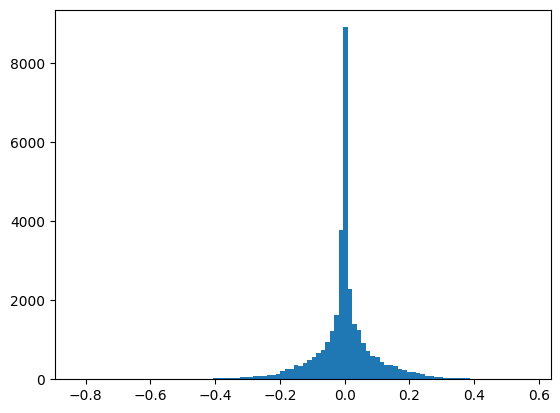

In [19]:
plt.hist(x0.flatten().numpy(), bins=100)
plt.show()

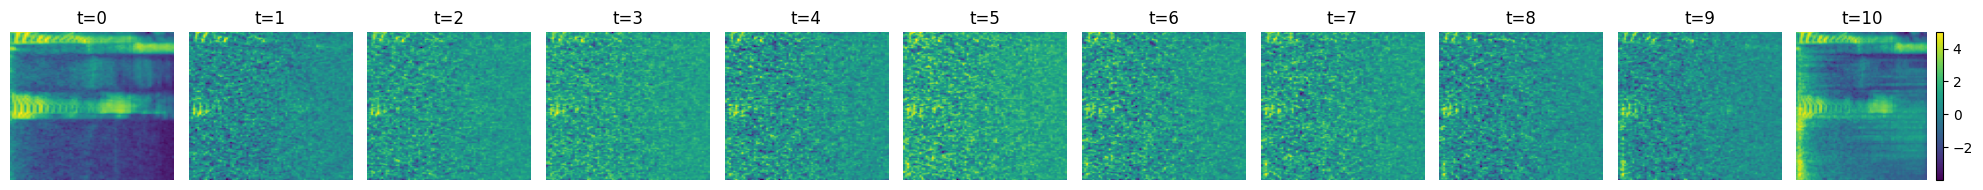

In [5]:
torch.manual_seed(0)
x0, x1 = dataset[0]
trajectory = scheduler.deterministic_sample(x0, x1, return_trajectory=True, noise='inference')
fig, axs = plt.subplots(1, 11, figsize=(20, 2))
for i in range(11):
    x = trajectory[i].unsqueeze(0)
    x = hifigan.encode(x)
    x = x.squeeze(0).permute(1, 0).numpy()
    # x is a spectrogra
    axs[i].imshow(x, aspect='auto', origin='lower')
    axs[i].axis('off')
    axs[i].set_title(f"t={i}")
    # make a colorbar
    if i == 10:
        cbar = plt.colorbar(axs[i].imshow(x, aspect='auto', origin='lower'), ax=axs[i])
plt.tight_layout()
plt.show()

torch.Size([1, 2, 256, 128])


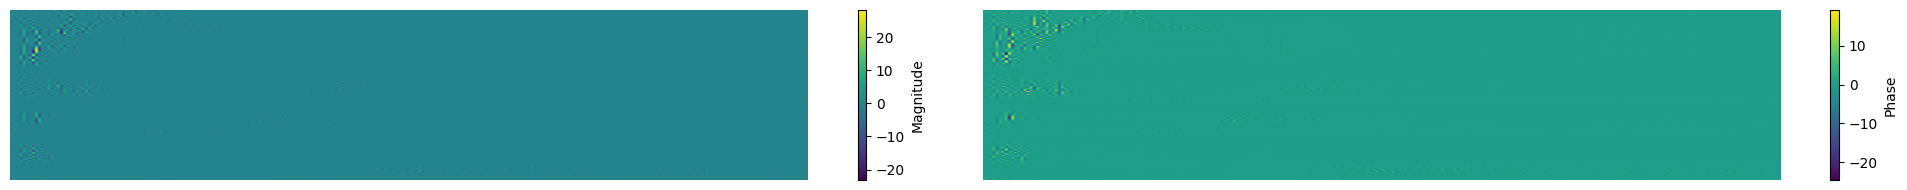

tensor(-24.6010) tensor(28.2365) tensor(0.0001) tensor(1.0107)


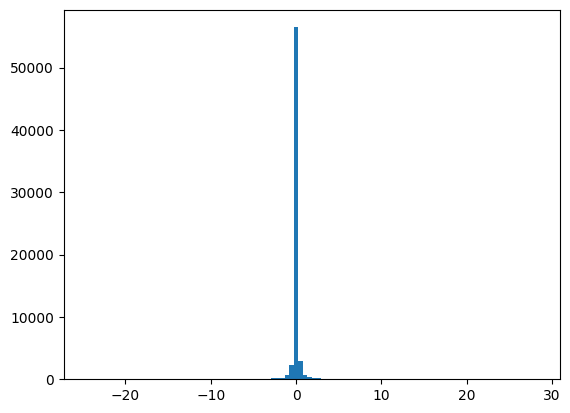

In [4]:
from src.networks import STFTEncoderDecoder
import torch
from src.dataset import AllLibri
from IPython.display import Audio, display
import matplotlib.pyplot as plt

dataset = AllLibri(length_seconds=1.05, sample_rate=16000)
stft = STFTEncoderDecoder(n_fft=510, hop_length=128)
audio = dataset[0].unsqueeze(0)
encoded = stft.encode(audio)
decoded = stft.decode(encoded)
print(encoded.shape)

display(Audio(audio.squeeze(0).cpu().numpy(), rate=16000))
display(Audio(decoded.squeeze(0).cpu().numpy(), rate=16000))

fig, axs = plt.subplots(1, 2, figsize=(20, 2))
axs : list[plt.Axes]
axs[0].imshow(encoded.squeeze(0)[0].permute(1, 0).numpy(), aspect='auto', origin='lower')
axs[0].axis('off')
axs[1].imshow(encoded.squeeze(0)[1].permute(1, 0).numpy(), aspect='auto', origin='lower')
axs[1].axis('off')
# add colorbar
cbar = plt.colorbar(axs[0].imshow(encoded.squeeze(0)[0].permute(1, 0).numpy(), aspect='auto', origin='lower'), ax=axs[0])
cbar.set_label('Magnitude')
cbar = plt.colorbar(axs[1].imshow(encoded.squeeze(0)[1].permute(1, 0).numpy(), aspect='auto', origin='lower'), ax=axs[1])
cbar.set_label('Phase')
plt.tight_layout()
plt.show()

print(encoded.min(), encoded.max(), encoded.mean(), encoded.std())
plt.hist(encoded.flatten().numpy(), bins=100)
plt.show()

In [1]:
from src.networks import StableAudioEncoder

model = StableAudioEncoder()
params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {params}")

/work3/s214630/Latent-DSB/.venv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Number of parameters: 156112514


In [ ]:
import torch

audio = torch.randn(1, 1, 44100 * 2, dtype=torch.float16)
with torch.no_grad():
    encoded = model.encode(audio)
print(encoded.shape)